In [1]:
# Import necessary libraries
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl

import pandas as pd
import verde as vd
import multiprocessing
from itertools import accumulate

from tqdm import tqdm

import xarray as xr

import time, array,random

from deap import base, creator, tools, algorithms

from CODES.modeling import create_seismic_model,calculate_parameters,calculate_parameters_from_vs
from CODES.dispersion_curves import create_velocity_model_from_profile,create_velocity_model_from_profile_vs,estimate_disp_from_velocity_model,compute_dispersion
from CODES.evolutionary_algorithm import process_depths,homogenize_depth_grid,bootstrap_hof_uncertainty

from parameters_py.config import (
					MODEL_NAME,FOLDER_OUTPUT,MAX_TOTAL,DEPTH_INTERVAL)

Reading configuration file: ./config_file.cnf


## Ensure reproducible results by fixing seeds for numpy

In [2]:
np.random.seed(42)  # any integer works

# Text based on:

- Gallagher, K., & Sambridge, M. (1994). **Genetic algorithms: a powerful tool for large-scale nonlinear optimization problems**. Comput. Geosci., 20(7–8), 1229–1236.
- Fortin, F. A., Rainville, F. M., Gardner, M., Parizeau, M., and Gagné, C. **DEAP: Evolutionary Algorithms Made Easy**, Journal of Machine Learning Research, pp. 2171-2175, no 13, jul 2012.
- Haskell, N. A. ,1953, **The dispersion of surface waves on multi-layered media**, Bull. Seism. Soc. Am. 43, 17-34.
- Xia, J., Miller, R. D.,  and Park,C. B., 1999, **Estimation of near‐surface shear‐wave velocity by inversion of Rayleigh waves**, GEOPHYSICS 1999 64:3, 691-700.
- Yamanaka, H., and H. Ishida, 1996, **Application of genetic algorithms to an inversion of surface-wave dispersion data**, Bulletin of the Seismological Society of America, 86, 436–444.

# Inversion of Surface-Wave Dispersion Data

**Rayleigh-wave phase velocity is the function of four parameters (Xia et al, 1999):**
    - S-wave velocity;
    - P-wave velocity;
    - Density; and
    - Layer thickness.

In the process of retrieving a 2D Vs profile from a 3D layered earth model, the primary step involves extracting 1D Vs profiles at multiple locations across the study area. Since surface wave analysis is most sensitive to vertical variations in Vs, the lateral variations are effectively averaged out during data processing. This results in a 1D Vs model, often referred to as a layered earth model, where Vs is determined as a function of depth, while other parameters such as Vp and density (ρ) may be either included or held constant. Each 1D Vs profile is assigned to the central location of its respective receiver spread, representing the most characteristic subsurface structure at that point. By accumulating multiple such profiles, each tagged with a unique surface coordinate, a 2D Vs profile is constructed through spatial interpolation. This method enables a continuous Vs representation along a given transect while maintaining the fundamental assumption of a layered earth model.


# Inputs and outputs

### Directory for saving model and other related stuffs: 

In [3]:
data_path = FOLDER_OUTPUT+MODEL_NAME+'/DATA/'

### Directory for saving figures: 

In [4]:
figures_path = FOLDER_OUTPUT+MODEL_NAME+'/FIGURES/'

---------

# **Comparison and final analysis:**

# Observed data

In [5]:
obs_data = pd.read_feather(data_path+'observed_data.feather')
obs_data

,receptor,station,density,velocity_s,depth,dispersion_curve,frequency
0,1,1,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.590...","[1000.2592585370571, 1000.2592585370571, 1000....","[-2.0, -1.9166666666666667, -1.833333333333333...","[144.95173072405785, 146.44557838030767, 147.9...","[100.0, 99.09090909090908, 98.18181818181817, ..."
1,6,2,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[1000.2592585370571, 1000.2592585370571, 1000....","[-2.0, -1.9166666666666667, -1.833333333333333...","[175.29509009905448, 177.09635963030425, 178.9...","[100.0, 99.09090909090908, 98.18181818181817, ..."
2,11,3,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[1000.2592585370571, 1000.2592585370571, 1000....","[-2.0, -1.9166666666666667, -1.833333333333333...","[175.29509009905448, 177.09635963030425, 178.9...","[100.0, 99.09090909090908, 98.18181818181817, ..."
3,16,4,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[1000.2592585370571, 1000.2592585370571, 1000....","[-2.0, -1.9166666666666667, -1.833333333333333...","[175.29509009905448, 177.09635963030425, 178.9...","[100.0, 99.09090909090908, 98.18181818181817, ..."
4,21,5,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.590...","[1000.2592585370571, 1000.2592585370571, 1000....","[-2.0, -1.9166666666666667, -1.833333333333333...","[174.54509009905456, 176.25983619280433, 178.0...","[100.0, 99.09090909090908, 98.18181818181817, ..."
5,26,6,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.590...","[1000.2592585370571, 1000.2592585370571, 1000....","[-2.0, -1.9166666666666667, -1.833333333333333...","[174.54509009905456, 176.25983619280433, 178.0...","[100.0, 99.09090909090908, 98.18181818181817, ..."
6,31,7,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.590...","[1000.2592585370571, 1000.2592585370571, 1000....","[-2.0, -1.9166666666666667, -1.833333333333333...","[168.7210666615552, 170.03366431780503, 171.39...","[100.0, 99.09090909090908, 98.18181818181817, ..."
7,36,8,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.590...","[1000.2592585370571, 1000.2592585370571, 1000....","[-2.0, -1.9166666666666667, -1.833333333333333...","[168.7210666615552, 170.03366431780503, 171.39...","[100.0, 99.09090909090908, 98.18181818181817, ..."
8,41,9,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.590...","[1000.2592585370571, 1000.2592585370571, 1000....","[-2.0, -1.9166666666666667, -1.833333333333333...","[168.7210666615552, 170.03366431780503, 171.39...","[100.0, 99.09090909090908, 98.18181818181817, ..."
9,46,10,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.590...","[1000.2592585370571, 1000.2592585370571, 1000....","[-2.0, -1.9166666666666667, -1.833333333333333...","[174.54509009905456, 176.25983619280433, 178.0...","[100.0, 99.09090909090908, 98.18181818181817, ..."


In [6]:
obs_depth_result_lst = []
obs_velocity_result_lst = []
obs_receptor_result_lst = []

depth_interval = -DEPTH_INTERVAL

for dativ in obs_data.iterrows():

    depths = dativ[1]['depth'].tolist()[::-1]
    vels_mean = dativ[1]['velocity_s'].tolist()[::-1]
    lst_receptor = dativ[1]['receptor']*2

    depths_fine = []
    vels_fine = []

    # Iterate through depth intervals
    for j in range(len(depths) - 1):
        # Create a new depth array within the interval with finer sampling
        depths_interval = np.arange(depths[j], depths[j + 1], depth_interval)

        depths_fine.extend(depths_interval)
        # Repeat the velocity value within the interval
        vels_fine.extend([vels_mean[j]] * len(depths_interval))

    obs_receptor_result_lst.append([lst_receptor]*len(vels_fine))
    obs_depth_result_lst.append(depths_fine)
    obs_velocity_result_lst.append(vels_fine)
    
obs_receptor_result_lst = np.array([item for sublist in obs_receptor_result_lst for item in sublist])
obs_depth_result_lst = np.array([item for sublist in obs_depth_result_lst for item in sublist])
obs_velocity_result_lst = np.array([item for sublist in obs_velocity_result_lst for item in sublist])

# We'll test this on the air temperature data from Texas
obs_coordinates = (obs_receptor_result_lst,obs_depth_result_lst)
obs_velocitys = obs_velocity_result_lst
obs_region = (0,100,-2,0)

obs_shape = (100,100)

# Now we can set up a gridder for the decimated data
grd_obs = vd.KNeighbors().fit(obs_coordinates, obs_velocitys)

# The 'grid' method can still make a geographic grid if we pass in a projection
# function that converts lon, lat into the easting, northing coordinates that
# we used in 'fit'. This can be any function that takes lon, lat and returns x,
# y. In our case, it'll be the 'projection' variable that we created above.
# We'll also set the names of the grid dimensions and the name the data
# variable in our grid (the default would be 'scalars', which isn't very
# informative).
observed_grid = grd_obs.grid(
    region=obs_region,
    shape=obs_shape,
    dims=["depth","receptor"],
    data_names="velocity",
)

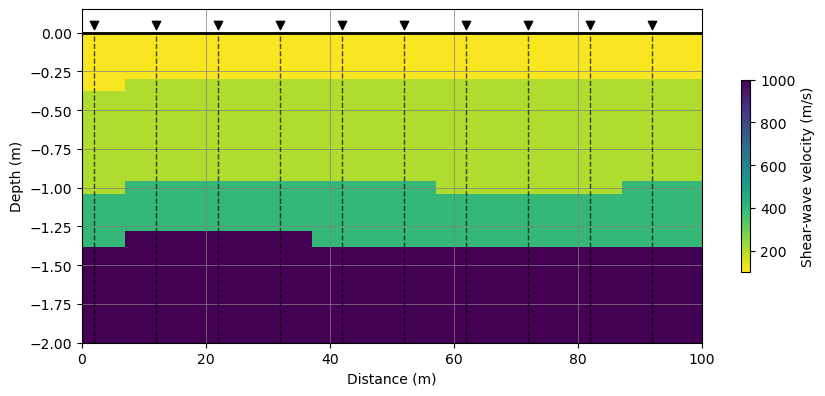

In [7]:
fig,ax = plt.subplots(1, 1, figsize=(10, 5))

im = plt.imshow(observed_grid.velocity.data, cmap='viridis_r',extent=[0, 100, -2.0, 0],vmin=100,vmax=1000,aspect=25,origin='lower')

for idx,ix in enumerate(obs_data['receptor']):
    ax.vlines(x=ix*2,ymin=-2.0,ymax=0,colors='k',lw=1.0,ls='--',alpha=0.7)
    ax.scatter(x=ix*2,y=0.05,color='k',marker='v')

ax.hlines(y=0,xmin=0,xmax=100,colors='k',lw=2,ls='-',alpha=1)
ax.set_xlabel('Distance (m)')
ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
ax.set_ylabel('Depth (m)')
plt.colorbar(im, ax=ax,fraction=0.15, shrink=0.5,label='Shear-wave velocity (m/s)')
fig.savefig(figures_path+'observed_slice_and_receptors.png')

# Inverted data

In [8]:
df_inversion = pd.read_feather(data_path+'inversion.feather')
df_inversion.head(1)

,Vs,thick,misfit,ngen,misfit_min,station,receptor,inversion
0,"[[119.0, 320.0, 834.0, 1025.29, 1031.44], [119...","[[0.59, 0.49, 0.31, 0.3, 0.03], [0.59, 0.49, 0...","[1.0334740437695098, 0.5192945634283621, 0.384...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0334740437695098, 0.5192945634283621, 0.384...",1,1,1


# Bootstrap of Hall of Fame solutions – Predicted Data

To assess parameter uncertainty, we applied a bootstrap approach to the best-performing solutions stored in the *hall of fame (HOF)* across multiple independent inversions. The HOF ensemble contains the lowest-misfit models identified by the evolutionary algorithm, representing the most probable solutions given the observed data.


- *Hall of fame (HOF)*: the best individual that ever lived in the population during the evolution. It is lexicographically sorted at all time so that the first element of the hall of fame is the individual that has the best first fitness value ever seen, according to the weights provided to the fitness at creation time.

## Methodology

#### Bootstrap Resampling:
- We resampled the HOF ensemble with replacement, randomly selecting subsets of solutions to compute statistical properties such as mean, median, and confidence intervals. This approach captures variability in the optimized parameters (Vs and thickness).

#### Uncertainty and Bias Reduction:
- Bootstrapping allows estimation of parameter uncertainty without assuming a theoretical distribution, which is especially useful for nonlinear inverse problems. It also reduces bias in estimators by approximating the true sampling distribution, yielding more robust parameter estimates.

see more in [datasciencedojo](https://datasciencedojo.com/blog/bootstrap-sampling/)

![Bootstrap Scheme](https://datasciencedojo.com/wp-content/uploads/bootstrap-scheme.png)

In [9]:
# List to store the expanded data
expanded_data = []

# Iterate over each row of the original DataFrame
for _, row in df_inversion.iterrows():
    station = row['station']
    receptor = row['receptor']
    inversion = row['inversion']
        
    # Check that Vs and thick have the same number of inner lists
    vs_lists = row['Vs']
    thick_lists = row['thick']
    misfit_min_lists = row['misfit_min']
    
    # For each inner list in Vs and thick, create a new row
    for vs_sublist, thick_sublist,misfit_min_list in zip(vs_lists, thick_lists,misfit_min_lists):
        expanded_data.append({
            'Vs': vs_sublist,
            'thick': thick_sublist,
            'misfit_min': misfit_min_list,
            'station': station,
            'receptor': receptor,
            'inversion': inversion
        })

# Create the new DataFrame
df_inversion_bootstrap = pd.DataFrame(expanded_data)

In [10]:
df_inversion_bootstrap

,Vs,thick,misfit_min,station,receptor,inversion
0,"[119.0, 320.0, 834.0, 1025.29, 1031.44]","[0.59, 0.49, 0.31, 0.3, 0.03]",1.033474,1,1,1
1,"[119.0, 320.0, 834.0, 1025.29, 1041.0]","[0.59, 0.49, 0.31, 0.3, 0.13]",0.519295,1,1,1
2,"[119.0, 320.0, 834.0, 1025.29, 1041.0]","[0.59, 0.49, 0.31, 0.3, 0.04]",0.384518,1,1,1
3,"[119.0, 320.0, 834.0, 1025.29, 1041.0]","[0.59, 0.49, 0.31, 0.3, 0.03]",0.323769,1,1,1
4,"[119.0, 320.0, 834.0, 1025.29, 1041.0]","[0.59, 0.49, 0.31, 0.43, 0.03]",0.285321,1,1,1
...,...,...,...,...,...,...
2095,"[114.0, 174.0, 706.0, 661.29, 1022.0]","[0.38, 0.38, 0.36, 0.04, 0.04]",0.058107,10,46,10
2096,"[114.0, 174.0, 706.0, 678.9300000000001, 1022.0]","[0.38, 0.38, 0.37, 0.04, 0.04]",0.058181,10,46,10
2097,"[114.0, 174.0, 706.0, 694.2, 1022.0]","[0.38, 0.38, 0.36, 0.04, 0.04]",0.058271,10,46,10
2098,"[114.0, 174.0, 706.0, 850.0, 1022.0]","[0.38, 0.38, 0.37, 0.04, 0.12]",0.058268,10,46,10


In [11]:
df_inversion_bootstrap[['depth_interval', 'Vs_interval']] = df_inversion_bootstrap.apply(homogenize_depth_grid, axis=1)

In [12]:
dic_bootstrap_results = []

for sta in  tqdm(df_inversion_bootstrap['station'].unique(),total=len(df_inversion_bootstrap['station'].unique()),desc='Station', leave=True, dynamic_ncols=True,colour='green'):
    dic_bootstrap_results.append(bootstrap_hof_uncertainty(df_inversion_bootstrap[df_inversion_bootstrap['station'] == sta]))

Station: 100%|██████████████████████████████████| 10/10 [00:01<00:00,  8.61it/s]


In [13]:
df_bootstrap_results = pd.DataFrame(dic_bootstrap_results)

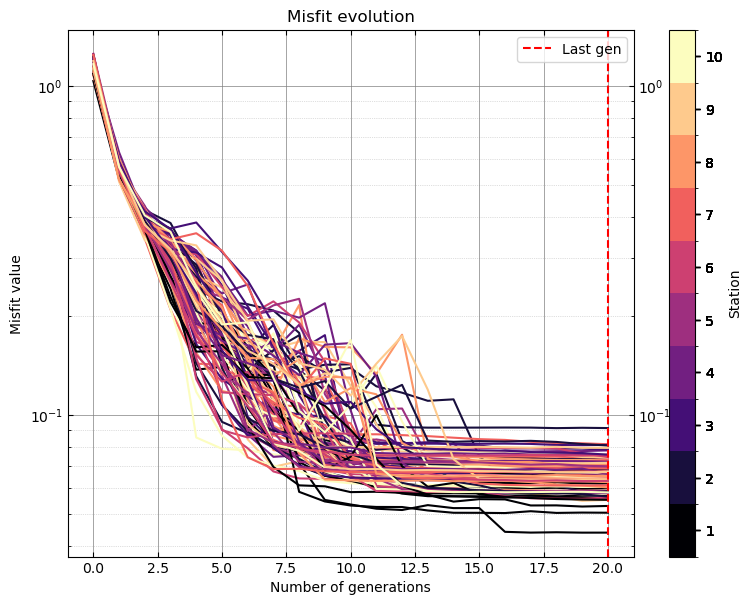

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

# cria um colormap (10 cores, normalizando de 1 a 10)
norm = plt.Normalize(vmin=df_inversion['station'].values.min(), vmax=df_inversion['station'].values.max())
# Norm para associar cada estação a uma cor
norm = mpl.colors.BoundaryNorm(boundaries=np.arange(df_inversion['station'].values.min()-0.5, 
                                                    df_inversion['station'].values.max()+1.5, 1),
                                                    ncolors=len(df_inversion['station'].values))
# forma moderna de pegar colormap
cmap = plt.get_cmap('magma', len(df_inversion['station'].values))  # ainda funciona para cores discretas

for dativ in df_inversion.iterrows():
    color = cmap(norm(dativ[1]['station']))
    ax.semilogy(dativ[1]['ngen'], dativ[1]['misfit'], '-',color=color)
        
ax.set_xlabel('Number of generations')
ax.set_ylabel('Misfit value')
ax.axvline(x=len(dativ[1]['ngen'])-1, color='red', linestyle='--', label='Last gen')
ax.legend(loc='upper right')
ax.grid(True, which='both')
plt.tight_layout()
ax.tick_params(axis='both', which='both', direction='in', 
               top=True, bottom=True, left=True, right=True,
               labelbottom=True, labeltop=False, labelleft=True,
               labelright=True)
ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
ax.set_title('Misfit evolution')

# ScalarMappable para a colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Colorbar discreta
cbar = plt.colorbar(sm, ax=ax, ticks=df_inversion['station'].values)
cbar.set_label("Station")
      
fig.savefig(figures_path+'misfit_total_.png', dpi=300)

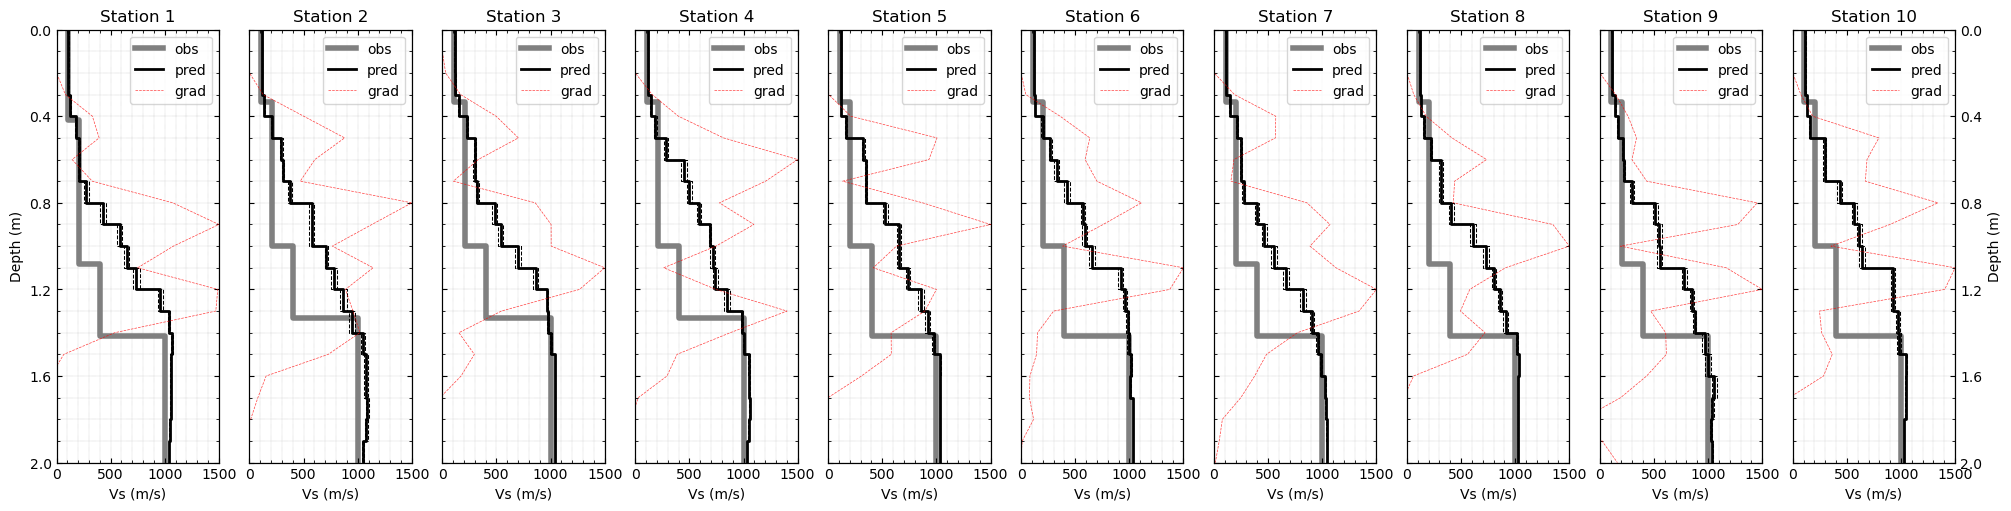

In [15]:
depth_result_lst = []
velocity_result_lst = [] 
receptor_result_lst = []

fig, axs = plt.subplots(1, 10, layout="constrained",figsize=(20, 5), facecolor='white',sharey=True)

for prof_n in df_bootstrap_results['station'].unique():
    
    ax = axs[prof_n-1]

    # --------------
    # Observed data

    observed_profile_df = obs_data.loc[prof_n-1]
    ax.step(observed_profile_df['velocity_s'],[-dep for dep in observed_profile_df['depth']], color='gray',ls='-',lw=4,where='post',zorder=-1,label='obs')

    # --------------
    # Predicted data
    
    profile_df = df_bootstrap_results.loc[prof_n-1]

    # --------------
    # Gradientes (dVs/dDepth)

    depth_pred = profile_df['mean_depth']
    vs_pred    = profile_df['mean_vs']
    
    depth_obs = observed_profile_df['depth']
    vs_obs    = observed_profile_df['velocity_s']
    
    grad_obs  = np.gradient(vs_obs, depth_obs)
    grad_pred = np.gradient(vs_pred, depth_pred)
      
    # ----------------
    # Plotting results
    
    ax.step(profile_df['mean_vs'],profile_df['mean_depth'], color='k',lw=2,ls='-',where='post',label='pred')
    ax.step(profile_df['ci_lower_vs'],profile_df['ci_lower_depth'], color='k',lw=0.75,ls='--',where='post')
    ax.step(profile_df['ci_upper_vs'],profile_df['ci_upper_depth'], color='k',lw=0.75,ls='--',where='post')

    # Axis x to gradient
    ax2 = ax.twiny()
    ax.plot([], [], color='r', lw=0.5,ls='--',alpha=0.75,label='grad')
    ax2.plot(grad_pred, depth_pred, color='r', lw=0.5,ls='--',alpha=0.75,label='grad')
    ax2.tick_params(axis='both', which='both', direction='in',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False,labelright=False)
    ax2.set_xlim(0,grad_pred.max())
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.4))
    
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(100))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(500))

    ax.set_xlabel('Vs (m/s)')

    ax.set_ylim(2,0)
    ax.set_xlim(0,1500)
    ax.grid(True, which='both',color='gray', linestyle=':', linewidth=0.25)
    ax.tick_params(axis='both', which='both', direction='in',top=True, bottom=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=False,labelright=False)
    ax.set_title('Station '+str(prof_n))
    if prof_n == df_inversion['station'].unique()[0]:
        ax.set_ylabel('Depth (m)')
        ax.tick_params(axis='both', which='both', direction='in',top=True, bottom=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=True,labelright=False)
    if prof_n == df_inversion['station'].unique()[-1]:
        ax.set_ylabel('Depth (m)')
        ax.yaxis.set_label_position('right')
        ax.tick_params(axis='both', which='both', direction='in',top=True, bottom=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=False,labelright=True)
    ax.legend()
fig.savefig(figures_path+'observed_predicted_profiles.png')


receptor_result_lst = np.array([item for sublist in receptor_result_lst for item in sublist])
depth_result_lst = np.array([item for sublist in depth_result_lst for item in sublist])
velocity_result_lst = np.array([item for sublist in velocity_result_lst for item in sublist])

In [16]:
df_inversion_bootstrap[['simulated_dispersion', 'simulated_frequency']] = (df_inversion_bootstrap.apply(compute_dispersion,axis=1,vs_col='Vs',depth_col='thick'))

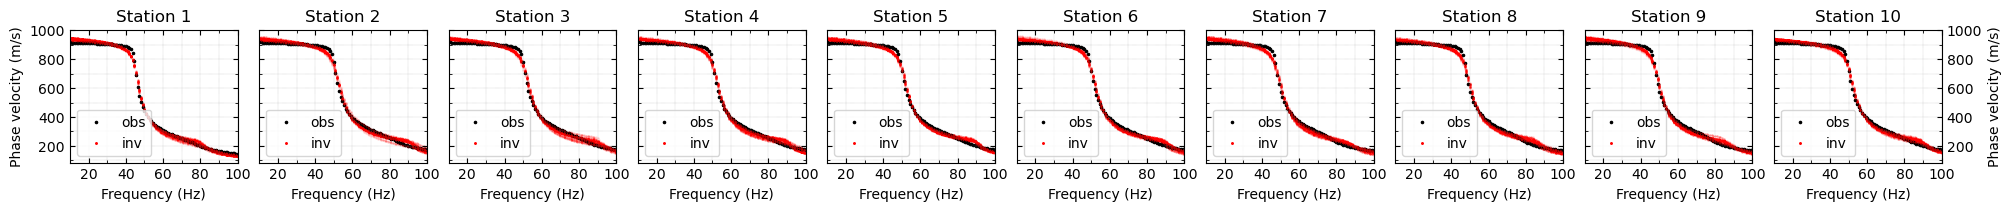

In [17]:
fig, axs = plt.subplots(1, 10, layout="constrained",figsize=(20, 2), facecolor='white',sharey=True)

for prof_n in df_inversion_bootstrap['station'].unique():
    
    ax = axs[prof_n-1]

    # --------------
    # Observed data

    observed_profile_df = obs_data.loc[prof_n-1]
    ax.scatter(observed_profile_df['frequency'],observed_profile_df['dispersion_curve'],marker='.',c='k',s=10,label='obs')

    # --------------
    # Predicted data
    
    profile_df = df_inversion_bootstrap[df_inversion_bootstrap['station'] == prof_n]
    for simulated_frequency, simulated_dispersion in zip(profile_df['simulated_frequency'],profile_df['simulated_dispersion']):
        ax.scatter(simulated_frequency,simulated_dispersion,marker='.',c='r',alpha=0.025,s=1)
    ax.scatter([],[],marker='.',c='r',s=5,label='inv')


    ax.yaxis.set_minor_locator(ticker.MultipleLocator(100))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(200))
    
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(20))

    ax.set_xlim(10,100)
    ax.set_xlabel('Frequency (Hz)')

    ax.grid(True, which='both',color='gray', linestyle=':', linewidth=0.25)
    ax.tick_params(axis='both', which='both', direction='in',top=True, bottom=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=False,labelright=False)
    ax.set_title('Station '+str(prof_n))

    if prof_n == df_bootstrap_results['station'].unique()[0]:
        ax.set_ylabel('Phase velocity (m/s)')
        ax.tick_params(axis='both', which='both', direction='in',top=True, bottom=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=True,labelright=False)

    if prof_n == df_bootstrap_results['station'].unique()[-1]:
        ax.set_ylabel('Phase velocity (m/s)')
        ax.yaxis.set_label_position('right')
        ax.tick_params(axis='both', which='both', direction='in',top=True, bottom=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=False,labelright=True)
    ax.legend(loc='lower left')
fig.savefig(figures_path+'observed_predicted_dispersion_curves.png')   

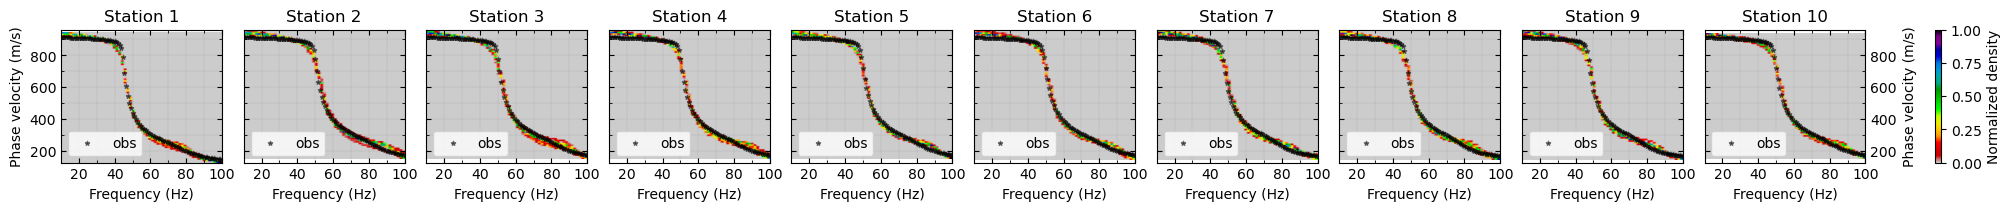

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

fig, axs = plt.subplots(1, 10, layout="constrained",
                        figsize=(20, 2), facecolor='white', sharey=True)

for prof_n in df_inversion_bootstrap['station'].unique():
    ax = axs[prof_n-1]

    # Predicted data as density
    profile_df = df_inversion_bootstrap[df_inversion_bootstrap['station'] == prof_n]

    # empilha todas freq/velocidades dessa estação
    all_freqs = np.concatenate(profile_df['simulated_frequency'].values)
    all_vels = np.concatenate(profile_df['simulated_dispersion'].values)

    # Define grade
    freq_bins = np.linspace(10, 100, 60)  # 60 bins de 10–100 Hz
    vel_bins = np.linspace(all_vels.min(), all_vels.max(), 80)  # ajuste conforme necessário

    H, xedges, yedges = np.histogram2d(all_freqs, all_vels, bins=[freq_bins, vel_bins])
    H = H.T  # para imshow

    # normaliza para densidade de probabilidade
    H = H / H.max()

    # plota heatmap semi-transparente
    im = ax.imshow(H,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],aspect='auto', origin='lower',cmap='nipy_spectral_r')
    
    # Observed data
    observed_profile_df = obs_data.loc[prof_n-1]
    ax.scatter(observed_profile_df['frequency'], observed_profile_df['dispersion_curve'],marker='*', c='k', s=10,alpha=0.5,label='obs')
    # Eixo/ticks/grid igual ao que você já tem
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(100))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(200))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.set_xlim(10, 100)
    ax.set_xlabel('Frequency (Hz)')
    ax.grid(True, which='both', color='gray', linestyle=':', linewidth=0.25)
    ax.tick_params(axis='both', which='both', direction='in', top=True, bottom=True,left=True, right=True, labelbottom=True, labeltop=False,labelleft=False, labelright=False)
    ax.set_title('Station ' + str(prof_n))

    # Y-labels nos extremos
    if prof_n == df_inversion_bootstrap['station'].unique()[0]:
        ax.set_ylabel('Phase velocity (m/s)')
        ax.tick_params(labelleft=True)
    if prof_n == df_inversion_bootstrap['station'].unique()[-1]:
        ax.set_ylabel('Phase velocity (m/s)')
        ax.yaxis.set_label_position('right')
        ax.tick_params(labelleft=False, labelright=True)

    ax.legend(loc='lower left')

# Opcional: barra de cores global para a densidade
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label('Normalized density')

fig.savefig(figures_path + 'observed_predicted_dispersion_curves_density.png', dpi=300)


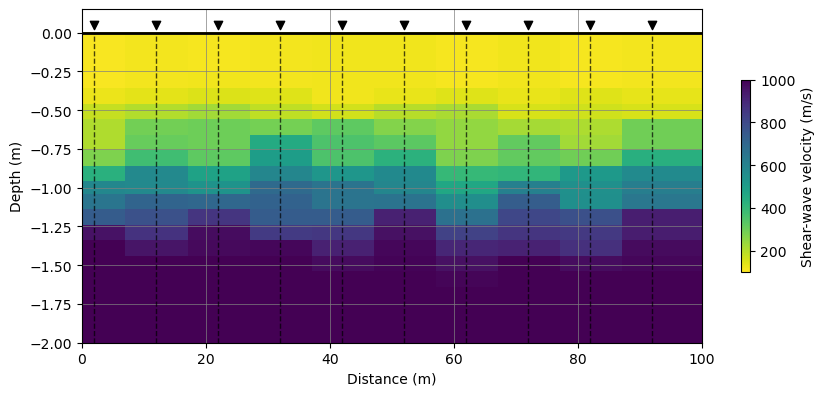

In [19]:
# GRID

velocity_result_lst = [i for i in df_bootstrap_results['mean_vs'].values]
receptor_result_lst =  [[int(i*2)]*len(j) for i,j in zip(df_bootstrap_results['receptor'].values,df_bootstrap_results['mean_vs'].values)]
depth_result_lst  = [-i for i in df_bootstrap_results['mean_depth'].values]

receptor_result_lst = np.array([item for sublist in receptor_result_lst for item in sublist])
depth_result_lst = np.array([item for sublist in depth_result_lst for item in sublist])
velocity_result_lst = np.array([item for sublist in velocity_result_lst for item in sublist])

# ----------
# Input data

coordinates = (receptor_result_lst, depth_result_lst)
velocitys = velocity_result_lst
region = (0,100,-2,0)
    
shape = (100,100)
    
# Now we can set up a gridder for the decimated data
grd_predic = vd.KNeighbors().fit(coordinates, velocitys)
    
# The 'grid' method can still make a geographic grid if we pass in a projection
predicted_grid = grd_predic.grid(region=region,shape=shape,dims=["depth","receptor"],data_names="velocity")

# plotting 
fig,ax = plt.subplots(1, 1, figsize=(10, 5))

im = plt.imshow(predicted_grid.velocity.data, cmap='viridis_r',extent=[0, 100, -2.0, 0],vmin=100,vmax=1000,aspect=25,origin='lower')

lst_receptor = list(set(receptor_result_lst))
for ix in lst_receptor:
    ax.vlines(x=ix,ymin=-2.0,ymax=0,colors='k',lw=1.0,ls='--',alpha=0.7)
    ax.scatter(x=ix,y=0.05,color='k',marker='v')

ax.hlines(y=0,xmin=0,xmax=100,colors='k',lw=2,ls='-',alpha=1)
ax.set_xlabel('Distance (m)')
ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
ax.set_ylabel('Depth (m)')
plt.colorbar(im, ax=ax,fraction=0.15, shrink=0.5,label='Shear-wave velocity (m/s)')
fig.savefig(figures_path+'inversion_slice_and_receptors.png')

# Error

In [20]:
deviation_grid = observed_grid - predicted_grid

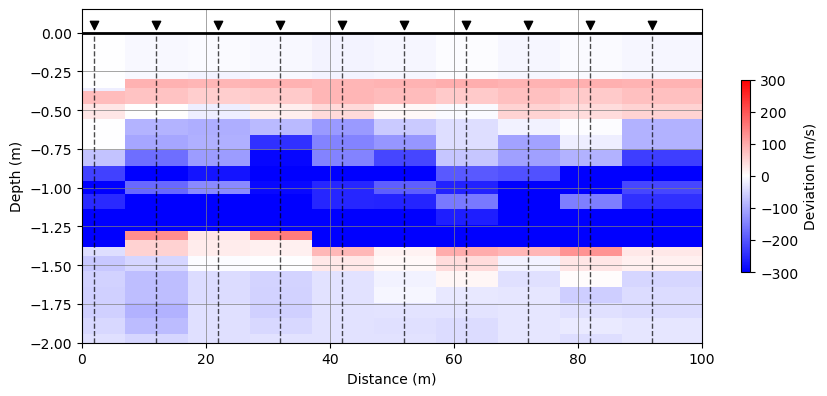

In [21]:
fig,ax = plt.subplots(1, 1, figsize=(10, 5))

im = plt.imshow(deviation_grid.velocity.data, cmap='bwr',extent=[0, 100, -2.0, 0],vmin=-300,vmax=300,aspect=25,origin='lower')

for idx,ix in enumerate(lst_receptor):
    ax.vlines(x=ix,ymin=-2.0,ymax=0,colors='k',lw=1.0,ls='--',alpha=0.7)
    ax.scatter(x=ix,y=0.05,color='k',marker='v')

ax.hlines(y=0,xmin=0,xmax=100,colors='k',lw=2,ls='-',alpha=1)
ax.set_xlabel('Distance (m)')
ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
ax.set_ylabel('Depth (m)')
plt.colorbar(im, ax=ax,fraction=0.15, shrink=0.5,label='Deviation (m/s)')
fig.savefig(figures_path+'deviation_observed_predicted_receptors.png')